In [1]:
import warnings
warnings.filterwarnings(action='once')
import xgboost as xgb
from sklearn.svm import SVR
import shap
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

from src.config import data_root
from sklearn.model_selection import train_test_split

shap.initjs()

In [2]:
priority_order = {
    "Trivial": 0,
    "Minor": 1,
    "Major": 2,
    "Critical": 3,
    "Blocker": 4,
}

type_order = {
    "Bug": 0,
    "Bug (Sub-task)": 1,
    "Epic": 2,
    "Improvement (Sub-task)": 3,
    "Internal Improvement": 4,
    "New Feature or Improvement": 5,
    "Prototype": 6,
    "Sub-task": 7,
}

In [3]:
# load the data
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_summed.csv'
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered.csv'
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered_real-data.csv'
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered_hours_real-data.csv'
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered_hours.csv'
# fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered_hours_10-days.csv'
fname = f'{data_root}/prediction_data/ticket_model/encoded_model_data_development_filtered_hours_10-days_real-data.csv'
data = pd.read_csv(fname)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
features = list(data)[:-1]
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
X_train_summary = shap.kmeans(X_train, 10)

In [4]:
# train
tree_model = xgb.train(params={
        "objective": "reg:squarederror",
        "colsample_bytree": 0.3,
        "learning_rate": 0.05,
        "max_depth": 40,
        "alpha": 50,
        "reg_lambda": 30
    },
    dtrain=d_train,
    num_boost_round=500,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=50
)
svm_model = SVR(C=1.0, epsilon=0.2)
svm_model.fit(X_train, y_train)

[0]	test-rmse:83.04597
Will train until test-rmse hasn't improved in 50 rounds.
[100]	test-rmse:58.60620
[200]	test-rmse:58.50005
Stopping. Best iteration:
[157]	test-rmse:58.40686



SVR(epsilon=0.2)

In [5]:
tree_explainer = shap.TreeExplainer(tree_model)
tree_shap_values = tree_explainer.shap_values(X, y=y)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


In [6]:
svm_explainer = shap.KernelExplainer(svm_model.predict, X_train_summary)
svm_shap_values = svm_explainer.shap_values(X, y=y)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

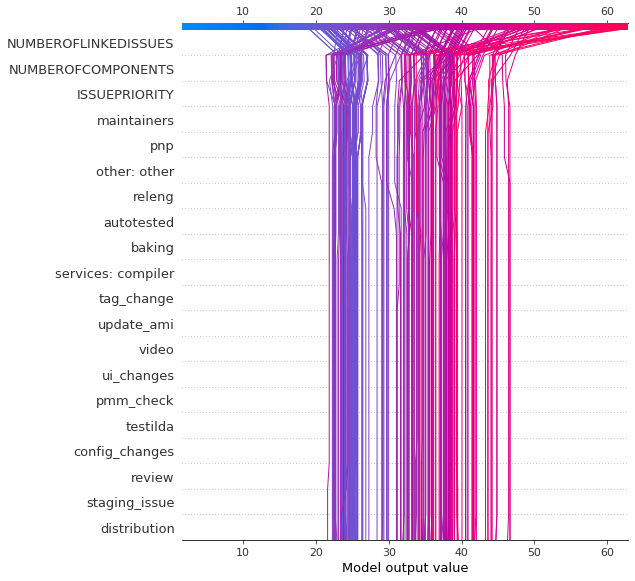

In [7]:
shap.decision_plot(svm_explainer.expected_value, svm_shap_values[0:200,:], X.iloc[0:200,:], feature_order='hclust')

In [8]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values[0,:], X.iloc[0,:])

In [9]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values[100,:], X.iloc[100,:])

In [10]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values[:1000,:], X.iloc[:1000,:])


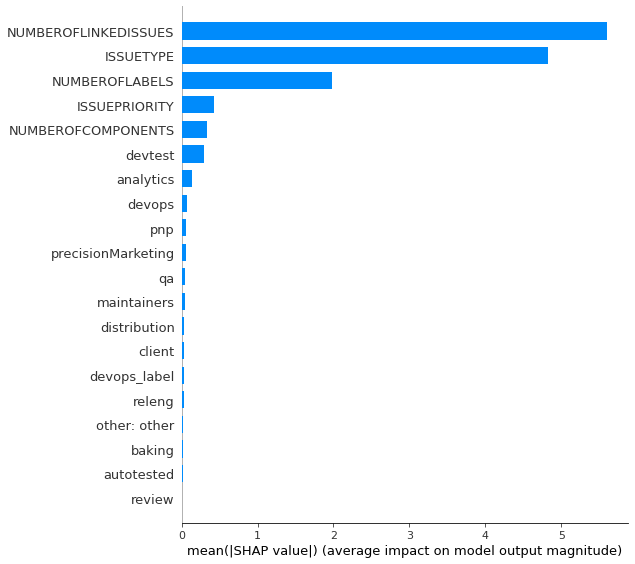

In [11]:
shap.summary_plot(svm_shap_values, X, plot_type="bar")

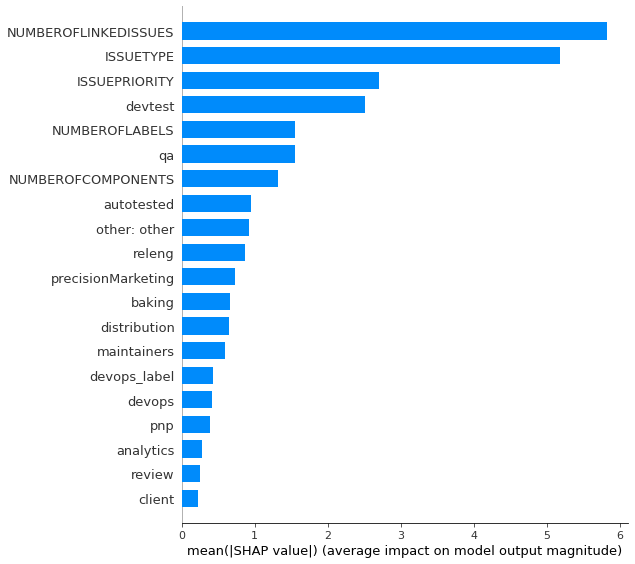

In [17]:
shap.summary_plot(tree_shap_values, X, plot_type="bar")

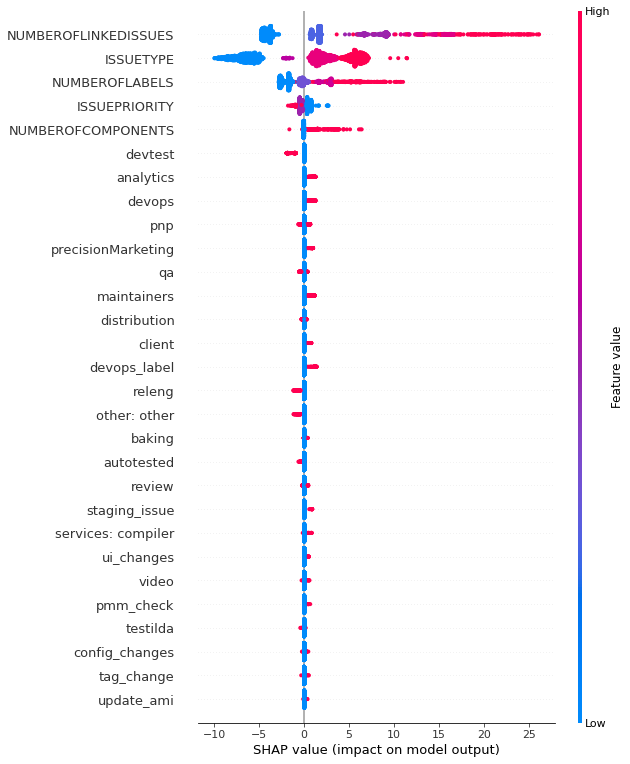

In [12]:
shap.summary_plot(svm_shap_values, X, max_display=len(features))

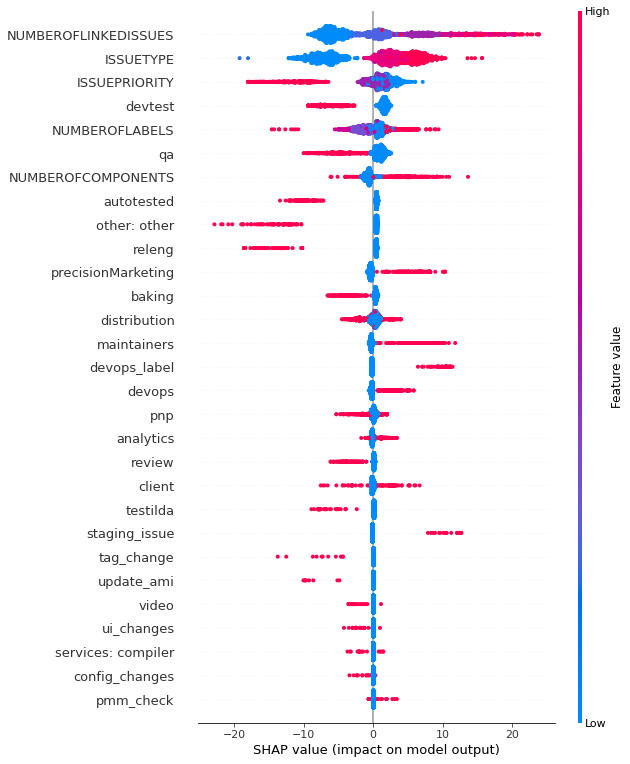

In [19]:
shap.summary_plot(tree_shap_values, X, max_display=len(features))

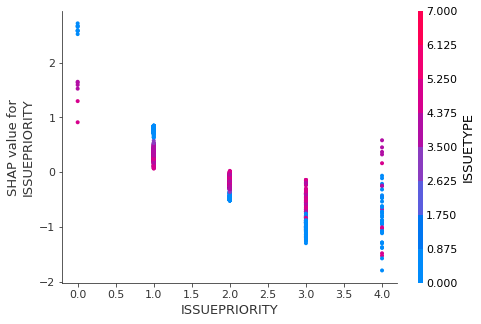

In [13]:
# for name in features:
#     shap.dependence_plot(name, svm_shap_values, X)
# shap.dependence_plot("ISSUEPRIORITY", svm_shap_values, X, interaction_index="NUMBEROFLINKEDISSUES")
shap.dependence_plot("ISSUEPRIORITY", svm_shap_values, X, interaction_index="ISSUETYPE")
# shap.dependence_plot("NUMBEROFCOMMENTS", svm_shap_values, X, interaction_index="DEGREEOFCYCLING")
# shap.dependence_plot("DEGREEOFCYCLING", svm_shap_values, X, interaction_index="NUMBEROFCOMMENTS")


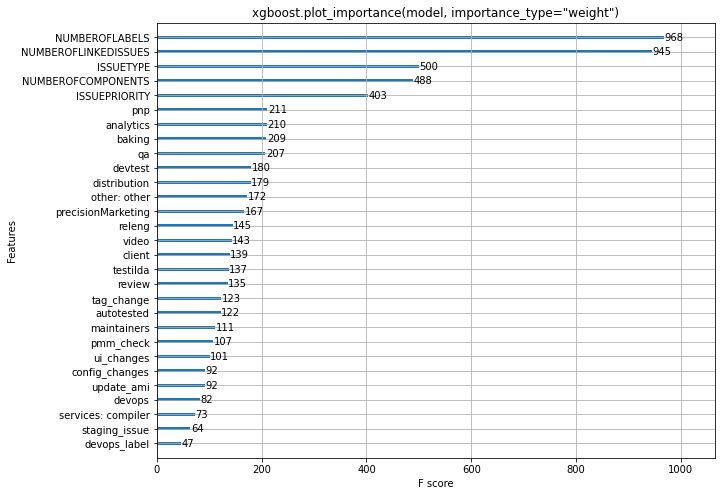

In [14]:
xgb.plot_importance(tree_model)
plt.title('xgboost.plot_importance(model, importance_type="weight")')
plt.show()

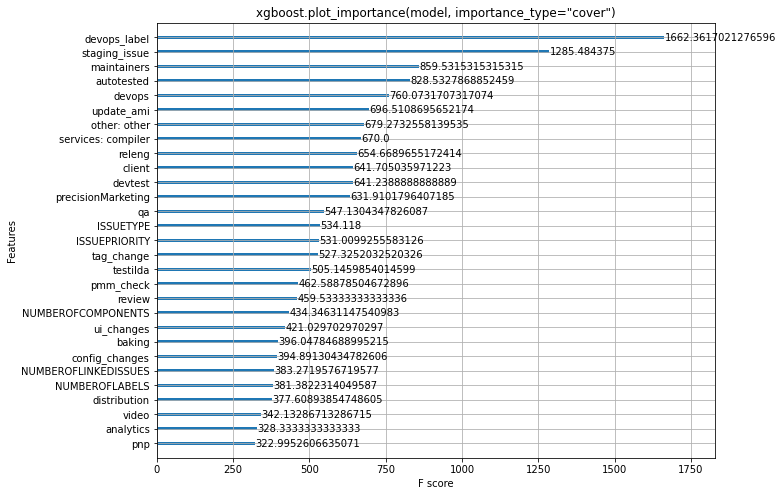

In [15]:
xgb.plot_importance(tree_model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

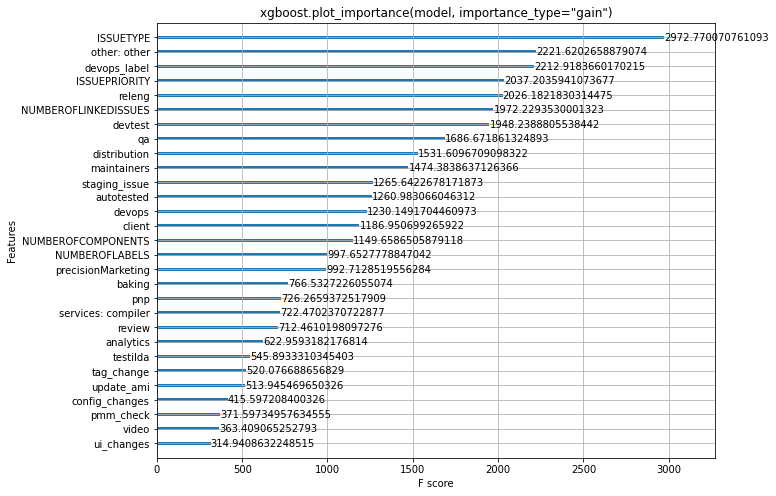

In [16]:
xgb.plot_importance(tree_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()